# Indigenous Trees

A look at some of the indigenous trees of Seattle.

## Setup

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [24]:
# Here we load our data set and filter out a few records.

dftrees = pd.read_csv('data/trees_of_seattle.csv', sep='|')
original_count = len(dftrees)

# Filtering out a few trees that are way outside the city range (which causes the maps to render funny).
dftrees = dftrees[dftrees['x'] > 1245000]
dftrees = dftrees[dftrees['y'] < 275000]

with open('data/trees_of_seattle.csv.metadata.json') as fin:
    dftrees_metadata_raw = fin.read()
    dftrees_metadata = json.loads(dftrees_metadata_raw)

print(f'Metadata for trees_of_seattle.csv: {repr(dftrees_metadata)}')
print(f'Discarded {original_count - len(dftrees)} out-of-bounds records. Final count {len(dftrees)}')

del dftrees_metadata_raw
del original_count

Metadata for trees_of_seattle.csv: {'version': '2', 'record_count': 246378, 'discarded_record_count': 8332, 'discarded_nonliving_trees_record_count': 6936, 'discarded_unknown_trees_record_count': 1396}
Discarded 7 out-of-bounds records. Final count 246371


In [25]:
# Split up the trees dataset into indigenous and non-indigenous sets.

dftrees_ind = dftrees[dftrees['indigenous']]
dftrees_non = dftrees[~dftrees['indigenous']]

print(f'Indigenous     {len(dftrees_ind):6} ({len(dftrees_ind) / len(dftrees) * 100:4.1f}%)')
print(f'Non-indigenous {len(dftrees_non):6} ({len(dftrees_non) / len(dftrees) * 100:4.1f}%)')

Indigenous      17107 ( 6.9%)
Non-indigenous 229264 (93.1%)


In [54]:
# Plot the location of specific species records in the city.

def plot_trees(title, df, legend_text=None):
    if legend_text is None:
        legend_text = title

    dftrees_bg = dftrees[~dftrees['objectid'].isin(df['objectid'])]
    dftrees_fg = dftrees[dftrees['objectid'].isin(df['objectid'])]

    fig, ax = plt.subplots(figsize=(12, 12))  # x-dimension gets "forgotten" after set_aspect().
    
    def scale_formatter(value, tick_number):
        return f'{value / 1_000_000.0:.2f}'
    
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(scale_formatter))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(scale_formatter))
    
    ax.scatter(dftrees_bg['x'], dftrees_bg['y'], s=.25, color='#DDD', label='Other')
    ax.scatter(dftrees_fg['x'], dftrees_fg['y'], s=.25, label=legend_text)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('Longitudinal Position\n(Millions of Feet)')
    ax.set_ylabel('Latitudinal Position\n(Millions of Feet)')
    ax.set_title(title)
    ax.legend(scatterpoints=1, markerscale=4, title='Legend')
    
    plt.show()

## Overview

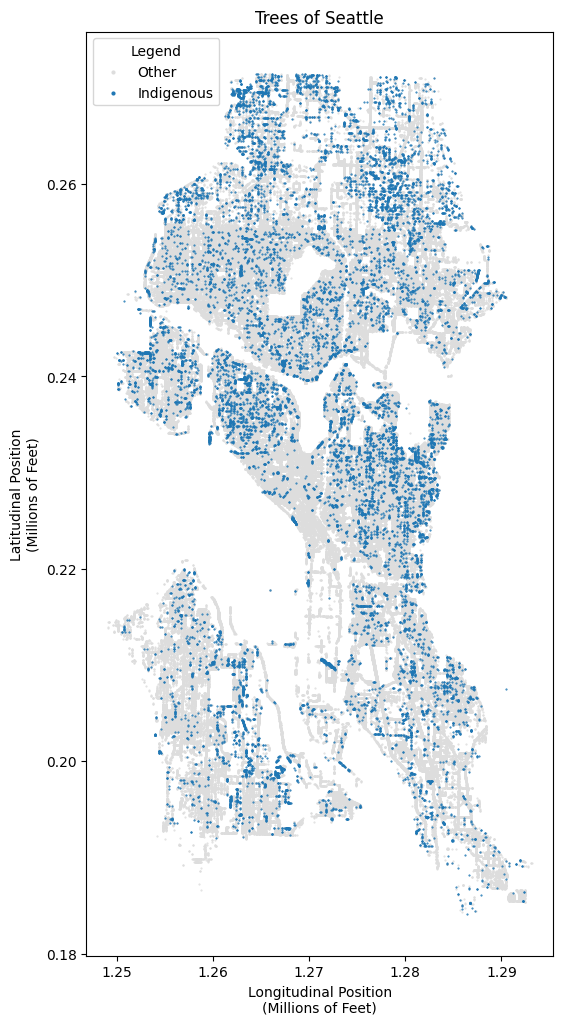

In [57]:
# Plot the location of trees in the city.

plot_trees('Trees of Seattle', dftrees_ind, legend_text='Indigenous')

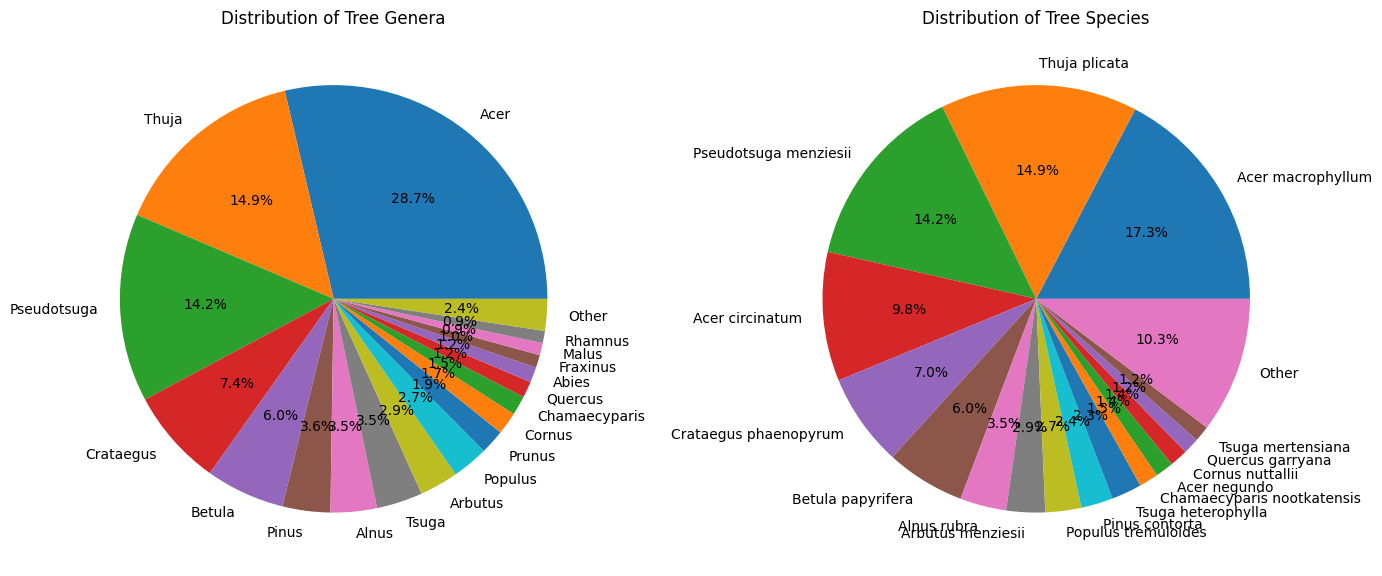

In [44]:
# Show the distribution of the various indigenous genera and species in Seattle.

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

def plot_genera(ax, cutoff_fraction):
    indigenous_counts = dftrees_ind['genus'].value_counts()
    
    cum_fractions = (indigenous_counts / indigenous_counts.sum()).cumsum()
    before_cutoff = indigenous_counts[cum_fractions < cutoff_fraction]
    after_cutoff = indigenous_counts[cum_fractions >= cutoff_fraction]
    others = pd.Series([after_cutoff.sum()], index=['Other'])

    result_counts = pd.concat([before_cutoff, others])

    result_counts.plot(
        kind ='pie',
        autopct='%1.1f%%',
        legend=False,
        labels=result_counts.index,
        ax=ax,
    )

    ax.set_title('Distribution of Tree Genera')
    
def plot_species(ax, cutoff_fraction):
    indigenous_counts = dftrees_ind['scientificname'].value_counts()
    
    cum_fractions = (indigenous_counts / indigenous_counts.sum()).cumsum()
    before_cutoff = indigenous_counts[cum_fractions < cutoff_fraction]
    after_cutoff = indigenous_counts[cum_fractions >= cutoff_fraction]
    others = pd.Series([after_cutoff.sum()], index=['Other'])

    result_counts = pd.concat([before_cutoff, others])

    result_counts.plot(
        kind ='pie',
        autopct='%1.1f%%',
        legend=False,
        labels=result_counts.index,
        ax=ax,
    )

    ax.set_ylabel('')
    ax.set_title('Distribution of Tree Species')


plot_genera(axes[0], 0.98)
plot_species(axes[1], 0.90)

plt.tight_layout()
plt.show()

# TODO - Clean up percents.

## Scratch Space

In [23]:
print(dftrees_ind['scientificname'].value_counts()[-40:])

scientificname
Tsuga heterophylla               392
Chamaecyparis nootkatensis       249
Acer negundo                     236
Cornus nuttallii                 233
Quercus garryana                 210
Tsuga mertensiana                204
Fraxinus latifolia               165
Prunus serotina                  158
Malus fusca                      158
Rhamnus purshiana                157
Prunus emarginata                134
Pinus ponderosa                  112
Abies grandis                    107
Abies procera                     81
Taxus brevifolia                  80
Pinus monticola                   66
Amelanchier alnifolia             57
Cornus sericea                    57
Crataegus douglasii               56
Rhus glabra                       45
Juniperus scopulorum              41
Salix scouleriana                 36
Acer glabrum                      34
Picea sitchensis                  34
Pinus contorta var. latifolia     27
Juniperus communis                23
Picea engelmannii      

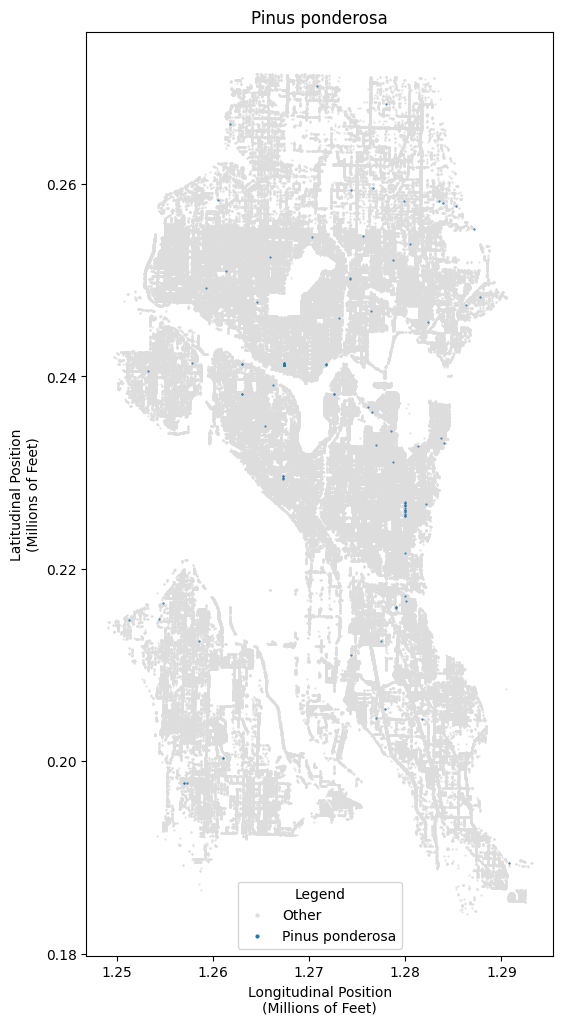

In [50]:
plot_trees('Pinus ponderosa', dftrees[dftrees['scientificname'] == 'Pinus ponderosa'])